In [1]:
# Packages
import nltk
import numpy as np
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# Import dataset

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
train = pd.read_csv('train.csv', header=None)
train['Text'] = train[1]+' '+train[2]
train = train.drop(columns=[1,2])

In [5]:
train[0] = train[0].map(lambda x: x-1)
train.rename(columns={0:'Sentiment'},inplace=True)

In [6]:
test = pd.read_csv('test.csv', header=None)
test['Text'] = test[1]+' '+test[2]
test = test.drop(columns=[1,2])

In [7]:
test[0] = test[0].map(lambda x: x-1)
test.rename(columns={0:'Sentiment'},inplace=True)

In [8]:
train.tail()

,Sentiment,Text
3599995,0,Don't do it!! The high chair looks great when ...
3599996,0,"Looks nice, low functionality I have used this..."
3599997,0,"compact, but hard to clean We have a small hou..."
3599998,0,what is it saying? not sure what this book is ...
3599999,1,Makes My Blood Run Red-White-And-Blue I agree ...


In [9]:
test.tail()

,Sentiment,Text
399995,0,Unbelievable- In a Bad Way We bought this Thom...
399996,0,"Almost Great, Until it Broke... My son recieve..."
399997,0,Disappointed !!! I bought this toy for my son ...
399998,1,Classic Jessica Mitford This is a compilation ...
399999,0,"Comedy Scene, and Not Heard This DVD will be a..."


In [10]:
train['Sentiment'].value_counts()

1    1800000
0    1800000
Name: Sentiment, dtype: int64

In [11]:
test['Sentiment'].value_counts()

1    200000
0    200000
Name: Sentiment, dtype: int64

# Text Processing

In [12]:
# 1. Tokenisation (casual module)
from nltk.tokenize import TweetTokenizer
Tokenizer = TweetTokenizer()
# 2. Remove punctuation
import string
# 3. Remove stopwords
from nltk.corpus import stopwords
# 4. Stemming
from nltk.stem.porter import PorterStemmer

In [13]:
def process_text(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_no_punctuation = [word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords = [word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    token = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    token = ' '.join(token)
    return token

In [14]:
def process_text_ez(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_lower = [word.lower() for word in tokenized]
    tokenized_stem = [PorterStemmer().stem(word) for word in tokenized_lower if word != '']
    token = ' '.join(tokenized_stem)
    return token

In [15]:
tqdm.pandas(desc="Progress bar")

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/bob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
fullset = pd.concat([train,test],axis=0,ignore_index=True)

In [18]:
fullset.tail()

,Sentiment,Text
3999995,0,Unbelievable- In a Bad Way We bought this Thom...
3999996,0,"Almost Great, Until it Broke... My son recieve..."
3999997,0,Disappointed !!! I bought this toy for my son ...
3999998,1,Classic Jessica Mitford This is a compilation ...
3999999,0,"Comedy Scene, and Not Heard This DVD will be a..."


In [22]:
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

In [59]:
fullset['Token'] = apply_by_multiprocessing(fullset['Text'], process_text, workers=8)

In [60]:
fullset.head()

,Sentiment,Text,Token
0,1,Stuning even for the non-gamer This sound trac...,stune even non-gam sound track beauti paint se...
1,1,The best soundtrack ever to anything. I'm read...,best soundtrack ever anyth i'm read lot review...
2,1,Amazing! This soundtrack is my favorite music ...,amaz soundtrack favorit music time hand intens...
3,1,Excellent Soundtrack I truly like this soundtr...,excel soundtrack truli like soundtrack enjoy v...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear play game know divi...


In [61]:
(fullset.Token.apply(len)).mean()

244.62794725

In [62]:
fullset.tail()

,Sentiment,Text,Token
3999995,0,Unbelievable- In a Bad Way We bought this Thom...,unbeliev bad way bought thoma son huge thoma f...
3999996,0,"Almost Great, Until it Broke... My son recieve...",almost great broke ... son reciev birthday gif...
3999997,0,Disappointed !!! I bought this toy for my son ...,disappoint bought toy son love thoma toy need ...
3999998,1,Classic Jessica Mitford This is a compilation ...,classic jessica mitford compil wide rang mitfo...
3999999,0,"Comedy Scene, and Not Heard This DVD will be a...",comedi scene heard dvd disappoint get hope see...


In [66]:
fullset[['Sentiment','Token']].to_csv('fullset_processed.csv',index=0)

In [63]:
# Randomly split indexes 90/10
train_x, valid_x, train_y, valid_y = train_test_split(fullset['Token'], fullset['Sentiment'], train_size=0.9, random_state=1, stratify=fullset.Sentiment)

## Count Vectors as features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

print('# CV + 1-gram')
count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=10000)
count_vect_1n.fit(fullset['Token'])

print('# CV + 2-gram')
count_vect_2n = CountVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=10000)
count_vect_2n.fit(fullset['Token'])

print("# CV + 3-gram")
count_vect_3n = CountVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=10000)
count_vect_3n.fit(fullset['Token'])

# CV + 1-gram
# CV + 2-gram
# CV + 3-gram


In [ ]:
# Transform the training and validation data using count vectorizer object
print('# Finish 1n')
xtrain_count_1n =  count_vect_1n.transform(train_x)
xvalid_count_1n =  count_vect_1n.transform(valid_x)

print('# Finish 2n')
xtrain_count_2n =  count_vect_2n.transform(train_x)
xvalid_count_2n =  count_vect_2n.transform(valid_x)

print('# Finish 3n')
xtrain_count_3n =  count_vect_3n.transform(train_x)
xvalid_count_3n =  count_vect_3n.transform(valid_x)

## TF-IDF Vectors + N-gram as features

In [ ]:
print('# TF-IDF + 1-gram')
tfidf_vect_1n = TfidfVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_1n.fit(fullset['Token'])

print('# TF-IDF + 2-gram')
tfidf_vect_2n = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_2n.fit(fullset['Token'])

print('# TF-IDF + 3-gram')
tfidf_vect_3n = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_3n.fit(fullset['Token'])

In [ ]:
print('# Finish 1n')
xtrain_tfidf_1n =  tfidf_vect_1n.transform(train_x)
xvalid_tfidf_1n =  tfidf_vect_1n.transform(valid_x)

print('# Finish 2n')
xtrain_tfidf_2n =  tfidf_vect_2n.transform(train_x)
xvalid_tfidf_2n =  tfidf_vect_2n.transform(valid_x)

print('# Finish 3n')
xtrain_tfidf_3n =  tfidf_vect_3n.transform(train_x)
xvalid_tfidf_3n =  tfidf_vect_3n.transform(valid_x)

## Word2vec as features

In [ ]:
from gensim.models import word2vec

In [ ]:
sentence = [(i.split()) for i in fullset.Token]
w2vmodel = word2vec.Word2Vec(sentence, min_count=1, size=300, workers=8)

In [ ]:
w2vmodel.most_similar(['book'])

In [0]:
#train_w2v_x, valid_w2v_x, train_w2v_y, valid_w2v_y = train_test_split(fullset['Text'], train_sp['Sentiment'], train_size=0.8, random_state=1, stratify=train_sp.Sentiment)

In [ ]:
def get_sent_vec(size, sent, model):
    vec = np.zeros(size).reshape(1,size)
    count = 0
    for word in sent:
        try:
            vec += model[word].reshape(1,size)
            count += 1
        except:
            continue
    if count != 0:
        vec /= count
    return vec

def get_train_vec(train_x, valid_x, model):
    train_vec = np.concatenate([get_sent_vec(300, sent, model) for sent in train_x])
    test_vec = np.concatenate([get_sent_vec(300, sent, model) for sent in valid_x])
    return train_vec, test_vec

In [ ]:
# Lower + No punctuation + No stopwords+ Stemming
train_vec, valid_vec = get_train_vec(train_x, valid_x, w2vmodel)
# Lower words + Stemming
#train_w2v_vec, valid_w2v_vec = get_train_vec(train_w2v_x, valid_w2v_x, w2vmodel)

# Model Training (Traditional ML)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from statlearning import plot_confusion_matrix

In [ ]:
from sklearn import naive_bayes, svm, linear_model

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    trm = classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = trm.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    print('Accuracy:', accuracy_score(predictions, valid_y).round(4))
    print('Precision:', precision_score(predictions, valid_y).round(4))
    print('Recall:', recall_score(predictions, valid_y).round(4))
    print('F1 Score:', f1_score(predictions, valid_y).round(4))
    '''
    confusion = confusion_matrix(predictions, valid_y)
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
    plt.show()
    '''
    #print('AUC:', roc_auc_score(predictions, proba_y[:,1]).round(3),'\n')

##  Naive Bayes

In [ ]:
print("# Naive Bayes + Count Vectors + 1-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, xvalid_count_1n)

print("\n# Naive Bayes + Count Vectors + 2-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_2n, train_y, xvalid_count_2n)

print("\n# Naive Bayes + Count Vectors + 3-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_3n, train_y, xvalid_count_3n)

In [ ]:
print("# Naive Bayes + TF-IDF + 1-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\n# Naive Bayes + TF-IDF + 2-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)

print("\n# Naive Bayes + TF-IDF + 3-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

In [ ]:
print("# Naive Bayes + 1234 + Word2vec")
train_model(naive_bayes.BernoulliNB(), train_vec, train_y, valid_vec)

#print("\n# Naive Bayes + 14 + Word2vec")
#train_model(naive_bayes.BernoulliNB(), train_w2v_vec, train_y, valid_w2v_vec)

## SVM 

In [ ]:
print("SVM + Count Vectors + 1-gram")
train_model(svm.SVC(verbose=True), xtrain_count_1n, train_y, xvalid_count_1n)

print("\nSVM + Count Vectors + 2-gram")
train_model(svm.SVC(verbose=True), xtrain_count_2n, train_y, xvalid_count_2n)

print("\nSVM + Count Vectors + 3-gram")
train_model(svm.SVC(verbose=True), xtrain_count_3n, train_y, xvalid_count_3n)

In [ ]:
print("SVM + TF-IDF + 1-gram")
train_model(svm.SVC(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\nSVM + TF-IDF + 2-gram")
train_model(svm.SVC(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)

print("\nSVM + TF-IDF + 3-gram")
train_model(svm.SVC(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

In [ ]:
print("SVM + 1234 + Word2vec")
train_model(svm.SVC(), train_vec, train_y, valid_vec)

#print("\nSVM + 14 + Word2vec")
#train_model(svm.SVC(), train_w2v_vec, train_y, valid_w2v_vec)

## Logistic Regression 

In [ ]:
print("Logistic Regression + Count Vectors + 1-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_1n, train_y, xvalid_count_1n)

print("\nLogistic Regression + Count Vectors + 2-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_2n, train_y, xvalid_count_2n)

print("\nLogistic Regression + Count Vectors + 3-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_3n, train_y, xvalid_count_3n)

In [ ]:
print("Logistic Regression + TF-IDF + 1-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\nLogistic Regression + TF-IDF + 2-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_2n, train_y, xvalid_tfidf_3n)

print("\nLogistic Regression + TF-IDF + 3-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

In [ ]:
print("Logistic Regression + 1234 + Word2vec")
train_model(linear_model.LogisticRegression(), train_vec, train_y, valid_vec)

#print("\nLogistic Regression + 14 + Word2vec")
#train_model(linear_model.LogisticRegression(), train_w2v_vec, train_y, valid_w2v_vec)

# Model Training (DNN)

In [9]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [0]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
MAX_SEQUENCE_LENGTH = 128 
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

In [0]:
fullset['Text'] = fullset['Text'].apply(str)

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

# One-hot
tokenizer = Tokenizer()
tokenizer.fit_on_texts(fullset['Text'])
sequences = tokenizer.texts_to_sequences(fullset['Text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(fullset['Sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 1177501 unique tokens.
Shape of data tensor: (4000000, 128)
Shape of label tensor: (4000000, 2)


In [42]:
p1 = int(len(data)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(data)*(1-TEST_SPLIT))
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]
print('train rows: '+str(len(x_train)))
print('valid rows: '+str(len(x_val)))
print('test rows: '+str(len(x_test)))

train rows: 3200000
valid rows: 400000
test rows: 400000


## CNN

In [34]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
cnn.add(MaxPooling1D(3))
cnn.add(Flatten())
cnn.add(Dense(EMBEDDING_DIM, activation='relu'))
cnn.add(Dense(labels.shape[1], activation='softmax'))
cnn.summary()

W0719 11:37:35.117842 139969333942144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 11:37:35.121850 139969333942144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 11:37:35.131954 139969333942144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 11:37:35.158958 139969333942144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 11:37:35.170718 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          117750200 
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 250)          75250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 42, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1050100   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total para

In [0]:
# CNN + One-hot
cnn.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=64)


result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

In [0]:
# Word2vec
from keras.utils import plot_model
from keras.layers import Embedding

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if str(word) in w2vmodel:
        embedding_matrix[i] = np.asarray(w2vmodel[str(word)],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


In [0]:
# CNN + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn_w2v = Sequential()
cnn_w2v.add(embedding_layer)
cnn_w2v.add(Dropout(0.2))
cnn_w2v.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
cnn_w2v.add(MaxPooling1D(3))
cnn_w2v.add(Flatten())
cnn_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
cnn_w2v.add(Dense(labels.shape[1], activation='softmax'))
cnn_w2v.summary()

cnn_w2v.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = cnn_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = cnn_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          20127300  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 126, 250)          225250    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 42, 250)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10500)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)               3150300   
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 602       
Total para

[5.112500967597962, 0.6796]

## LSTM 

In [0]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm.add(Dense(labels.shape[1], activation='softmax'))
lstm.summary()

lstm.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=128)

result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 128, 100)          117750200 
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_13 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 117,867,979
Trainable params: 117,867,979
Non-trainable params: 0
______________________________________________________________

In [0]:
# Word2vec
from keras.utils import plot_model
from keras.layers import Embedding

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if str(word) in w2vmodel:
        embedding_matrix[i] = np.asarray(w2vmodel[str(word)],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)


In [0]:
# LSTM + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm_w2v = Sequential()
lstm_w2v.add(embedding_layer)
lstm_w2v.add(Dropout(0.2))
lstm_w2v.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_w2v.add(Dense(1, activation='sigmoid'))
lstm_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_w2v.add(Dense(labels.shape[1], activation='softmax'))
lstm_w2v.summary()

lstm_w2v.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = lstm_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = lstm_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          20127300  
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_18 (Dense)             (None, 300)               600       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 602       
Total params: 20,348,279
Trainable params: 220,979
Non-trainable params: 20,127,300
__________________________________________________________

[0.2884707634925842, 0.8802]

## Hybrid Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 100)          117750200 
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 126, 250)          75250     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 42, 250)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               194048    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               300       
__________

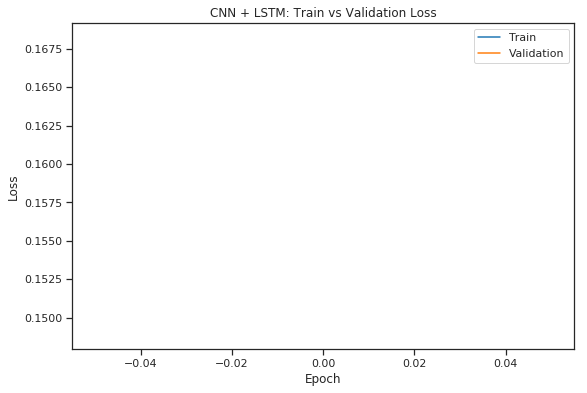

400000/400000 [==============================] - 454s 1ms/step
[Test] Loss: 0.15286792957790196
[Test] Accuracy: 0.9426625


In [43]:
# CNN + LSTM
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
hybrid.add(Dropout(0.2))
hybrid.add(Conv1D(250, 3, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=3))
hybrid.add(LSTM(128))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.add(Dense(EMBEDDING_DIM, activation='relu'))
hybrid.add(Dense(labels.shape[1], activation='softmax'))
hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hybrid.summary()

hybrid.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=128)

In [46]:
# CNN + LSTM
result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

400000/400000 [==============================] - 480s 1ms/step
[Test] Loss: 0.15286792957790196
[Test] Accuracy: 0.9426625


In [0]:
# CNN + LSTM + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid_w2v = Sequential()
hybrid_w2v.add(embedding_layer)
hybrid_w2v.add(Dropout(0.2))
hybrid_w2v.add(Conv1D(250, 3, activation='relu'))
hybrid_w2v.add(MaxPooling1D(pool_size=3))
hybrid_w2v.add(LSTM(128))
hybrid_w2v.add(Dense(2, activation='sigmoid'))
hybrid_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
hybrid_w2v.add(Dense(labels.shape[1], activation='softmax'))
hybrid_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hybrid_w2v.summary()

hybrid_w2v.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = hybrid_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN + LSTM + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = hybrid_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

# Optimisation (CV: Parameters & Features Selection)

# Reflection